# Key Estimation

In tonal music, the task of key estimation refers to identifying the main tonality of a musical piece. This is a useful first step for automatic harmonic analysis, automatic pitch spelling, etc.

In symbolic music, we usually need to identify the key of a piece from MIDI-like note information (MIDI pitch, onset, duration).

In [1]:
%matplotlib widget
# Let's import some stuff
import os

import numpy as np
import partitura as pt
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from scipy.stats import mode

from typing import Tuple, Union

from key_profiles import (
    build_key_profile_matrix, 
    key_prof_maj_kk,
    key_prof_min_kk,
    key_prof_maj_cbms,
    key_prof_min_cbms,
    key_prof_maj_kp,
    key_prof_min_kp,
    MAJOR_KEYS,
    MINOR_KEYS,
    KEYS,
    PITCH_CLASSES,
)

from partitura.utils.misc import PathLike

from key_estimation_utils import NOTEBOOK_DIR

%config InlineBackend.figure_format ='retina'

Here are different pitch distributions for major and minor keys. 

* **Krumhansl**: Krumhansl-Kessler Key Profiles, which were compiled empirically from human ratings of tonal hierarchy
* **CMBS**: A statistical profile compiled by David Temperley using the pitch class distributions of popular music.
* **Kostka-Payne**: Another statistical profile by Temperley, this time using the examples in Kostka and Payne's textbook of tonal harmony.

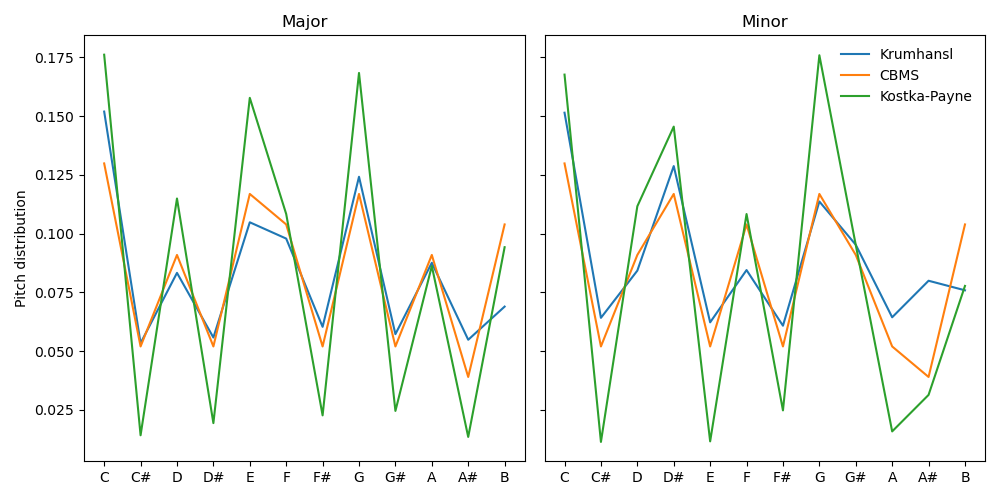

In [2]:
pitch_profiles = [
    (key_prof_maj_kk, key_prof_min_kk, "Krumhansl"),
    (key_prof_maj_cbms, key_prof_min_cbms, "CBMS"),
    (key_prof_maj_kp, key_prof_min_kp, "Kostka-Payne"),
]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

for pmaj, pmin, profile in pitch_profiles:
    ax1.plot(pmaj / pmaj.sum(), label=profile)
    ax2.plot(pmin / pmaj.sum(), label=profile)
ax1.set_title("Major")
ax2.set_title("Minor")
ax1.set_xticks(ticks=np.arange(12))
ax1.set_xticklabels(MAJOR_KEYS)
ax2.set_xticks(ticks=np.arange(12))
ax2.set_xticklabels(MAJOR_KEYS)
ax1.set_ylabel("Pitch distribution")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

The key profile matrix is a $24 \times 12$ matrix that contains the key profiles for each key. The first 12 rows represent the key profiles for major keys and the last 12 rows represent the profiles for minor keys.

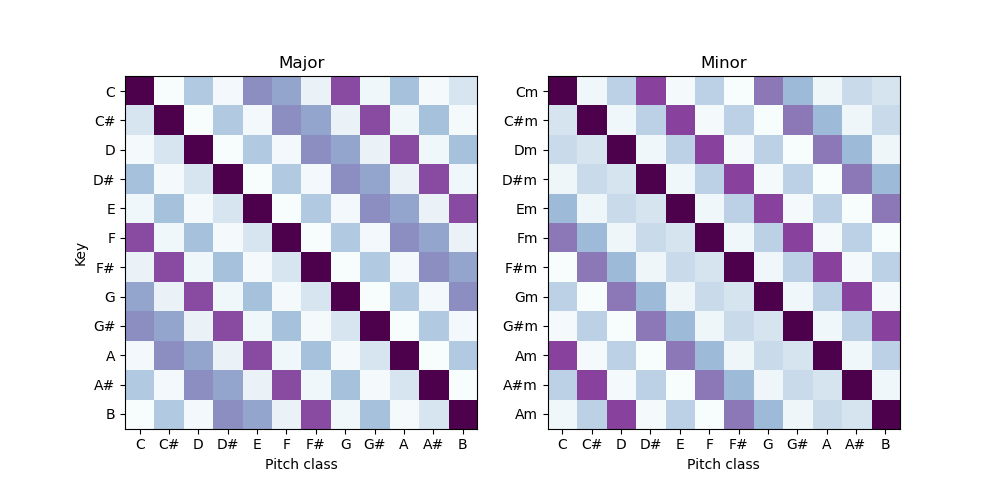

In [3]:
key_profile_matrix = build_key_profile_matrix("kk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Major")
ax1.imshow(key_profile_matrix[:12], aspect="equal", cmap="BuPu")
ax1.set_xticks(range(12))
ax1.set_xticklabels(PITCH_CLASSES)
ax1.set_yticks(range(12))
ax1.set_yticklabels(MAJOR_KEYS)
ax1.set_xlabel("Pitch class")
ax1.set_ylabel("Key")

ax2.set_title("Minor")
ax2.imshow(key_profile_matrix[12:], aspect="equal", cmap="BuPu")
ax2.set_xticks(range(12))
ax2.set_xticklabels(PITCH_CLASSES)
ax2.set_yticks(range(12))
ax2.set_yticklabels(MINOR_KEYS)
ax2.set_xlabel("Pitch class")

plt.show()

## Krumhansl-Schmuckler Key Estimation

The key is C


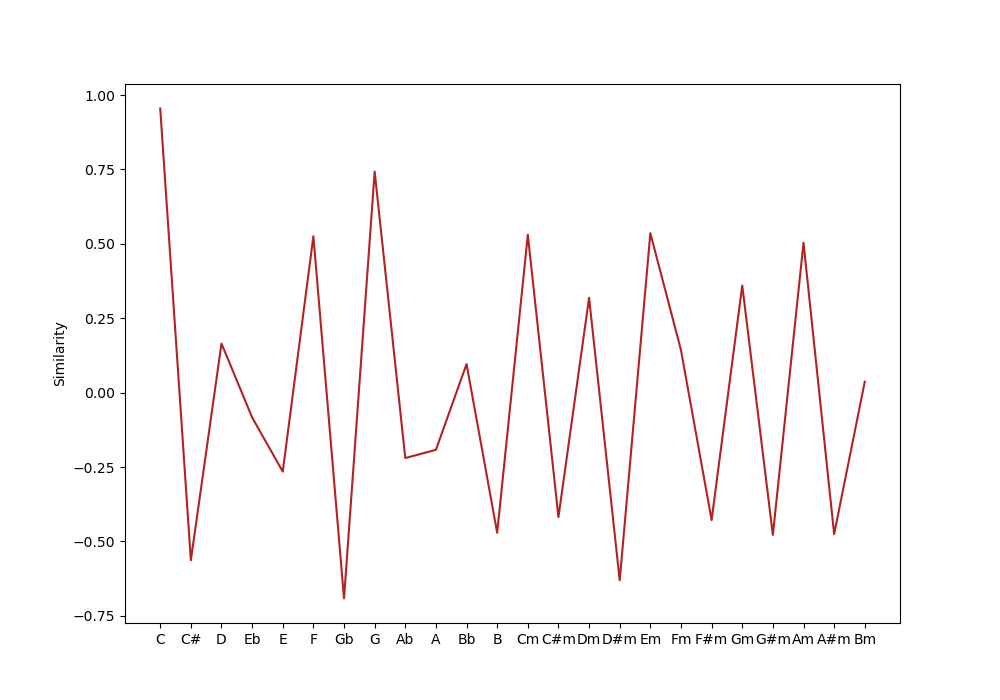

In [4]:
from partitura.utils.music import get_time_units_from_note_array

key_profile_matrix = build_key_profile_matrix("kk")

midi_fn = os.path.join(NOTEBOOK_DIR, "example_data", "01.mid")
perf = pt.load_performance_midi(midi_fn)
note_array = perf.note_array()

# Modulations!
# note_array["pitch"] += 1

normalize_distribution = False


def corr(x, y):
    return np.corrcoef(x, y)[0, 1]


similarity_func = corr

# Get pitch classes
pitch_classes = np.mod(note_array["pitch"], 12)

# Compute weighted key distribution
pitch_distribution = np.array(
    [
        note_array["duration_sec"][np.where(pitch_classes == pc)[0]].sum()
        for pc in range(12)
    ]
)

if normalize_distribution:
    # normalizing is unnecessary for computing the correlation, but might
    # be necessary for other similarity metrics
    pitch_distribution = pitch_distribution / pitch_distribution.sum()

# Compute correlation with key profiles
similarity = np.array(
    [similarity_func(pitch_distribution, kp) for kp in key_profile_matrix]
)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(similarity, c="firebrick")
ax.set_xticks(range(24))
ax.set_xticklabels(KEYS)
ax.set_ylabel("Similarity")
key = KEYS[similarity.argmax()]

print(f"The key is {key}")

Partitura includes an implementation of this method!

In [5]:
from partitura.musicanalysis.key_identification import estimate_key

midi_fn = os.path.join(NOTEBOOK_DIR, "example_data", "03.mid")
perf = pt.load_performance_midi(midi_fn)
key = estimate_key(note_array, key_profiles="krumhansl_kessler")
print(f"The key is {key}")

The key is C


## Comparing keys

We define a simple tonal distance with relation to the circle of fifths.

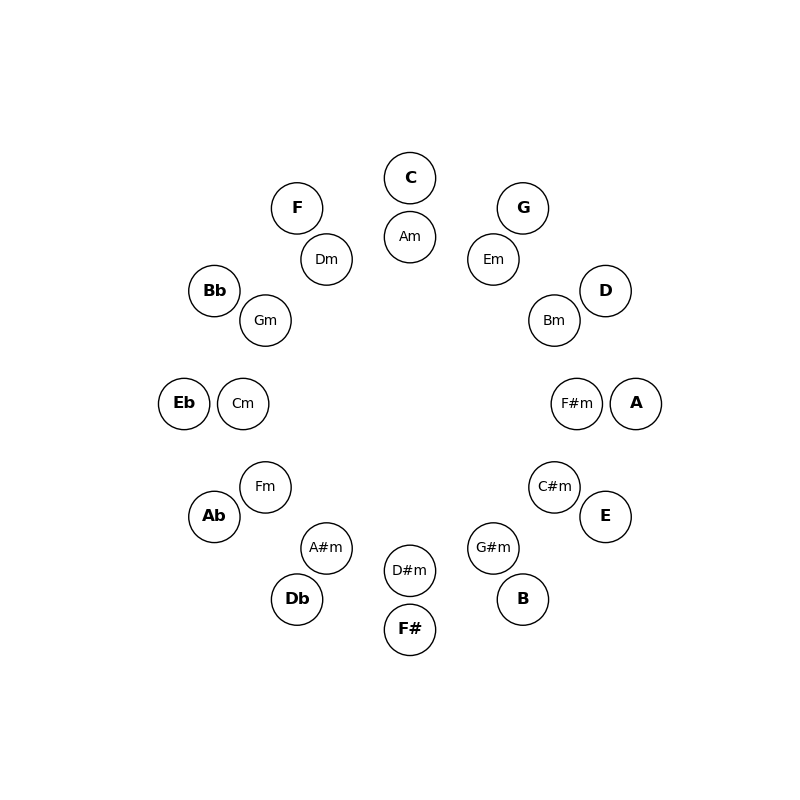

In [6]:
from key_estimation_utils import InteractiveCircleOfFifths
interactive_cof = InteractiveCircleOfFifths()


1.0


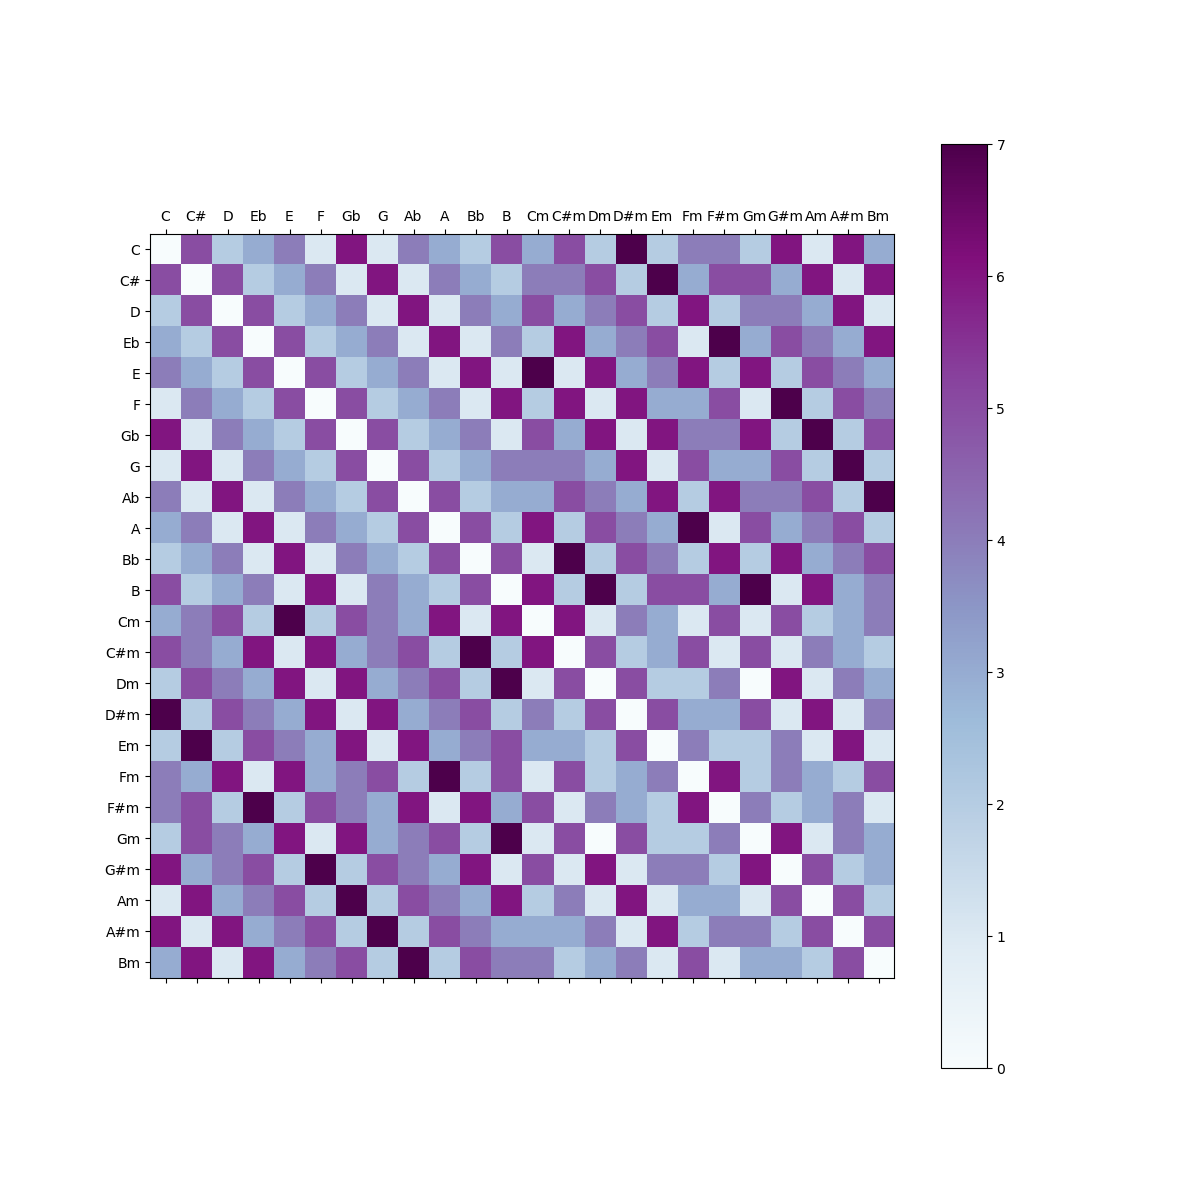

In [7]:
from key_estimation_challenge import compare_keys, KEY_COORDINATES

print(compare_keys("C", "Am"))

pairwise_tonal_distance = np.zeros((24, 24))
for i, ikey in enumerate(KEYS):
    for j, jkey in enumerate(KEYS):
        pairwise_tonal_distance[i, j] = compare_keys(ikey, jkey)

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.matshow(
    pairwise_tonal_distance,
    aspect="equal",
    cmap="BuPu",
)
ax.set_xticks(range(24))
ax.set_xticklabels(KEYS)
ax.set_yticks(range(24))
ax.set_yticklabels(KEYS)
plt.colorbar(im)
plt.show()